<font size = 4>**COSC-576 Assignment2** </font>  
<font size = 3>**Yingxuan Li**</font>

<font size = 3>**Question1 Modify your XOR Neural Net using PyTorch**</font>

**1. Modify your neural network from problem 3 of Assignment 1 to use binary classification instead of mean-square error. Evaluate your new neural network with your XOR test dataset generated in the previous assignment. Compare your modified neural network with your previous one (from last assignment), and write down your discovery.**

In this neural network, I change the loss function from nn.MSELoss() to nn.BCELoss() and apply sigmoid function to the output. In the case of the same hyperparameters, we can evaluate the effects of two functions by comparing the scatter graphs and loss funciton values of the them under the test dataset.  

In the scatter plot of BCE function, almost all test data can be classified correctly. So you can see two types of dots are clearly colored and there are almost no boundary results in the scatter plot. However, in the scatter plot of the MSE function, some test data produces boundary results that cannot be clearly classified. In other words, in the lower left corner of the scatter plot you'll see some greenish dots.  

We can also compare the value of loss function for BCE and MSE.  
Binary cross entropy for test data =  0.004118710434683286  
Mean squared error for test data = 0.008743415934888399  

In conclusion, the effect of using binary classification is better than mean-square error.


<center>
<img src="https://github.com/linkia-xuan/Markdown_photo/raw/master/MSE.png" width=490 height=325 />
Figure1 MSE test result
<img src="https://github.com/linkia-xuan/Markdown_photo/raw/master/BCE.png" width=495 height=330 />
Figure2 BCE test result
</center>

NN(
  (linear0): Linear(in_features=2, out_features=100, bias=True)
  (linear1): Linear(in_features=100, out_features=100, bias=True)
  (out): Linear(in_features=100, out_features=1, bias=True)
  (non_linear1): LeakyReLU(negative_slope=0.01)
  (non_linear2): Sigmoid()
  (dropout): Dropout(p=0.0, inplace=False)
)
epoch =     0     5000	 train =     5000	  0.2759	dev =      101	  0.0695
epoch =     1    10003	 train =     5003	  0.0782	dev =      101	  0.0362
epoch =     2    15006	 train =     5003	  0.0563	dev =      101	  0.0218
epoch =     3    20009	 train =     5003	  0.0497	dev =      101	  0.0202
epoch =     4    25002	 train =     4993	  0.0422	dev =      101	  0.0241
epoch =     5    30005	 train =     5003	  0.0387	dev =      101	  0.0195
epoch =     6    35008	 train =     5003	  0.0371	dev =      101	  0.0144
epoch =     7    40001	 train =     4993	  0.0341	dev =      101	  0.0137
epoch =     8    45004	 train =     5003	  0.0349	dev =      101	  0.0096
epoch =     9    500

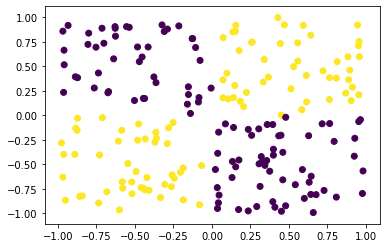

Test results:


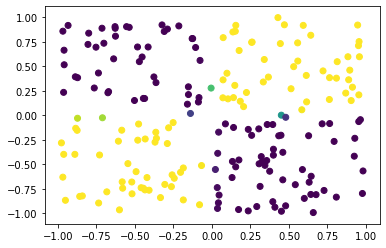

In [50]:
import time
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from random import shuffle
from torch.autograd import Variable

###############################################################################
use_cuda = torch.cuda.is_available()
use_cuda = False

###############################################################################
# hyperparameters
###############################################################################
nLinear1 = 100
nLinear2 = 100

learning_rate = 0.001


# regularization (dropout, L2, batch size) -- lecture 4
dropout = 0.0

L2_lambda = 0.0

batch_size = 10

# control amount of training data
nTrainPoints = 10
nTrainPoints = 5003

nDevPoints = 101

nTestPoints = 200

DesiredTrainSamples = 50000

DisplayInterval = 5000

###############################################################################
class NN(nn.Module):
###############################################################################
    def __init__(self, input_size, nLinear1, nLinear2, output_size, dropout=0.0):
        super(NN, self).__init__()
        self.linear0 = nn.Linear(input_size, nLinear1)
        self.linear1 = nn.Linear(nLinear1, nLinear2)

        self.out = nn.Linear(nLinear2, 1)    # output 

        self.non_linear1 = nn.LeakyReLU(negative_slope=0.01, inplace=False)
        self.non_linear2 = nn.Sigmoid()

        self.dropout = nn.Dropout(dropout)

        for p in self.parameters(): # optionally apply different randomization
            if p.dim() > 1:
                # all random initializations from PyTorch with default parameters
                nn.init.constant_(p, val=1.0)   # this is a really bad idea -- don't use it
                nn.init.orthogonal_(p, gain=1)
                nn.init.sparse_(p, sparsity=0.9, std=0.01)

                nn.init.uniform_(p, a=0.0, b=1.0)   # this works poorly, see next
                nn.init.uniform_(p, a=-1.0, b=1.0)  # default is a=0.0, b=1.0
                nn.init.normal_(p, mean=0.0, std=1.0)

                nn.init.kaiming_uniform_(p, a=0, mode='fan_in', nonlinearity='leaky_relu')
                nn.init.kaiming_normal_(p, a=0, mode='fan_in', nonlinearity='leaky_relu')

                nn.init.xavier_uniform_(p)
                nn.init.xavier_normal_(p)

###########################################################################
    def forward(self, inputs):
        nPoints = len(inputs)
        x = inputs.view(nPoints, -1)

        x = self.linear0(x)
        x = self.non_linear1(x)
        x = self.dropout(x)

        x = self.linear1(x)
        x = self.non_linear1(x)
        x = self.dropout(x)

        x = self.out(x)
        out = self.non_linear2(x)

        return out

###############################################################################
def train(model, optimizer, criterion, data, idx_list, update=True):
    model.zero_grad()

    nPoints = len(idx_list)
    inputs = []
    targets = []
    loss = 0

    for i in idx_list:
        inputs.append(data[0][i])
        targets.append(data[1][i])

    #inputs  = Variable(torch.Tensor(inputs))   # Variable is no longer needed
    inputs = torch.Tensor(inputs)
    targets = torch.Tensor(targets)

    if use_cuda:
        inputs = inputs.cuda()
        targets = targets.cuda()

    outputs = model(inputs)     # "model()" invokes "model.forward()"
    outputs = outputs.view(-1)
    loss += criterion(outputs, targets)
  #   loss += criteria[0](output0.view(-1), targets0)
  #  loss1 += criteria[1](output1.view(-1), targets1)

    if update:
        loss.backward()
        optimizer.step()

    return loss.item(), nPoints

###############################################################################
def train_model(model, train_data, dev_data):
    train_list  = [i for i in range(len(train_data[0]))]    # list of indexes of training data
    dev_list    = [i for i in range(len(dev_data[0]))]      # list of indexes of dev data
    
    #criterion = nn.BCEWithLogitsLoss(reduction='sum')
    criterion = nn.BCELoss(reduction='sum')


    # choose an optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=L2_lambda, amsgrad=False)

###############################################################################
# train model 
###############################################################################
    start = time.time()

    nEpochs = ((DesiredTrainSamples - 1) // len(train_list)) + 1

    TrainLoss = 0
    TrainPoints = 0
    TotalTrainSamples = 0
    nCurrentSamples = 0

    model.train()
    for epoch in range(nEpochs):
        shuffle(train_list)     # make it a habit to shuffle data, even if random
        #print(train_list)
        for i in range(0, len(train_list), batch_size):
            loss, nPoints = train(model, optimizer, criterion, train_data, train_list[i:i+batch_size], update=True)
            #print(i, nTrainPairs, loss / nPoints)
            TrainLoss += loss
            TrainPoints += nPoints
            TotalTrainSamples += nPoints
            nCurrentSamples += nPoints

            if (nCurrentSamples >= DisplayInterval) or (TotalTrainSamples >= DesiredTrainSamples):
                model.eval()
                DevLoss, DevPoints = train(model, optimizer, criterion, dev_data, dev_list, update=False)
                model.train()
                print("epoch = %5d %8d\t train = %8d\t%8.4f\tdev = %8d\t%8.4f" % (epoch, TotalTrainSamples, TrainPoints, TrainLoss / TrainPoints, DevPoints, DevLoss / DevPoints))

                TrainLoss = 0
                TrainPoints = 0
                nCurrentSamples -= DisplayInterval

            if TotalTrainSamples >= DesiredTrainSamples:
                break

        if TotalTrainSamples >= DesiredTrainSamples:
            break

    torch.save(model, 'XOR.pth')

    return

###############################################################################
def func(x0, x1):
    l = len(x0)
    y = []
    for i in range(l):
        if x0[i]*x1[i]>0:
            y.append(1)
        else:
            y.append(0)
    return np.array(y)

###############################################################################
def create_data(data_spec):
    nPoints = data_spec
    rng = np.random.RandomState(0)
    x = 2*rng.rand(nPoints, 2)-1
    x0 = x[: , 0]
    x1 = x[: , 1]
    y = func(x0, x1)
    #y1 = func1(x)
    x = np.array([x0, x1]).T
    return [x, y]

###############################################################################
if __name__ == "__main__":
    start = time.time()

    ###############################################################################
    # create data
    ###############################################################################
    train_data  = create_data(nTrainPoints)
    dev_data    = create_data(nDevPoints)
    test_data   = create_data(nTestPoints)

    ###############################################################################
    # create model 
    ###############################################################################
    model = NN(2, nLinear1, nLinear2, 1, dropout)
    print(model)
    if use_cuda:
        model = model.cuda()

    train_model(model, train_data, dev_data)

    end = time.time()
    elapsed = end - start
    print("time = %.2f (sec)\n" % (elapsed))

    # let's see our neural network in action
    show_results = True
    #show_results = False
    if show_results:
        x, y = test_data
        out = model(torch.Tensor(x))
        #print(out0)
        out = out.detach().cpu().numpy()[:,0] # remove output values from network, move to cpu, convert to numpy
   #     out1 = out1.detach().cpu().numpy()[:,0]
        #print(out0)
        #print(out0.shape)
        BCE0 = (((y - out)**2).sum()) / len(y)
        print("binary cross entropy for test data =", BCE0)

     # show test data 
        plt.scatter(x[:,0], x[:,1], c=y)
        print("Test dataset:")
        plt.show()
    # show result  
        #out[out >= 0.5] =1
        #out[out < 0.5] = 0
        plt.scatter(x[:,0], x[:,1], c=out)
        print("Test results:")
        plt.show()

**2. Modify your new XOR neural network to include an L2 regularization. Evaluate the new neural network with your XOR test dataset generated in the previous assignment. Compare your new neural network with the previous one(from this assignment), and write down your discovery.**

I modify my new neural network from previous question to add an L2 regularization to the loss function. After trying different values, I choose 0.0001 as the value of L2_lambda since this value has a better effect. 

Comparing the scatter graphs between this question and previous question, we could find that the boundary of this scatter plot is smoother than previous one. So it show that L2 regularization has the effect of smoothing boundary.  

Let's look at the values of loss function.  
In this network, binary cross entropy for test data = 0.0020080460227999385  
In previous network, binary cross entropy for test data = 0.004118710434683286  
The loss function value of this network is less than previous one, which means this test results is more closer to the targets than previous one.  

So adding an L2 regularization to neural network has a positive effect.

NN(
  (linear0): Linear(in_features=2, out_features=100, bias=True)
  (linear1): Linear(in_features=100, out_features=100, bias=True)
  (out): Linear(in_features=100, out_features=1, bias=True)
  (non_linear1): LeakyReLU(negative_slope=0.01)
  (non_linear2): Sigmoid()
  (dropout): Dropout(p=0.0, inplace=False)
)
epoch =     0     5000	 train =     5000	  0.3099	dev =      101	  0.1068
epoch =     1    10003	 train =     5003	  0.0815	dev =      101	  0.0498
epoch =     2    15006	 train =     5003	  0.0625	dev =      101	  0.0259
epoch =     3    20009	 train =     5003	  0.0498	dev =      101	  0.0653
epoch =     4    25002	 train =     4993	  0.0469	dev =      101	  0.0161
epoch =     5    30005	 train =     5003	  0.0416	dev =      101	  0.0182
epoch =     6    35008	 train =     5003	  0.0362	dev =      101	  0.0155
epoch =     7    40001	 train =     4993	  0.0346	dev =      101	  0.0108
epoch =     8    45004	 train =     5003	  0.0320	dev =      101	  0.0105
epoch =     9    500

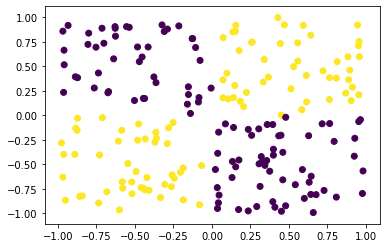

Test results:


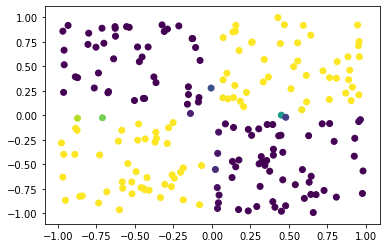

In [51]:
import time
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from random import shuffle
from torch.autograd import Variable

###############################################################################
use_cuda = torch.cuda.is_available()
use_cuda = False

###############################################################################
# hyperparameters
###############################################################################
nLinear1 = 100
nLinear2 = 100

learning_rate = 0.001


# regularization (dropout, L2, batch size) -- lecture 4
dropout = 0.0

L2_lambda = 0.0001

batch_size = 10

# control amount of training data
nTrainPoints = 10
nTrainPoints = 5003

nDevPoints = 101

nTestPoints = 200

DesiredTrainSamples = 50000

DisplayInterval = 5000

###############################################################################
class NN(nn.Module):
###############################################################################
    def __init__(self, input_size, nLinear1, nLinear2, output_size, dropout=0.0):
        super(NN, self).__init__()
        self.linear0 = nn.Linear(input_size, nLinear1)
        self.linear1 = nn.Linear(nLinear1, nLinear2)

        self.out = nn.Linear(nLinear2, 1)    # output 

        self.non_linear1 = nn.LeakyReLU(negative_slope=0.01, inplace=False)
        self.non_linear2 = nn.Sigmoid()

        self.dropout = nn.Dropout(dropout)

        for p in self.parameters(): # optionally apply different randomization
            if p.dim() > 1:
                # all random initializations from PyTorch with default parameters
                nn.init.constant_(p, val=1.0)   # this is a really bad idea -- don't use it
                nn.init.orthogonal_(p, gain=1)
                nn.init.sparse_(p, sparsity=0.9, std=0.01)

                nn.init.uniform_(p, a=0.0, b=1.0)   # this works poorly, see next
                nn.init.uniform_(p, a=-1.0, b=1.0)  # default is a=0.0, b=1.0
                nn.init.normal_(p, mean=0.0, std=1.0)

                nn.init.kaiming_uniform_(p, a=0, mode='fan_in', nonlinearity='leaky_relu')
                nn.init.kaiming_normal_(p, a=0, mode='fan_in', nonlinearity='leaky_relu')

                nn.init.xavier_uniform_(p)
                nn.init.xavier_normal_(p)

###########################################################################
    def forward(self, inputs):
        nPoints = len(inputs)
        x = inputs.view(nPoints, -1)

        x = self.linear0(x)
        x = self.non_linear1(x)
        x = self.dropout(x)

        x = self.linear1(x)
        x = self.non_linear1(x)
        x = self.dropout(x)

        x = self.out(x)
        out = self.non_linear2(x)

        return out

###############################################################################
def train(model, optimizer, criterion, data, idx_list, update=True):
    model.zero_grad()

    nPoints = len(idx_list)
    inputs = []
    targets = []
    loss = 0

    for i in idx_list:
        inputs.append(data[0][i])
        targets.append(data[1][i])

    #inputs  = Variable(torch.Tensor(inputs))   # Variable is no longer needed
    inputs = torch.Tensor(inputs)
    targets = torch.Tensor(targets)

    if use_cuda:
        inputs = inputs.cuda()
        targets = targets.cuda()

    outputs = model(inputs)     # "model()" invokes "model.forward()"
    outputs = outputs.view(-1)
    loss += criterion(outputs, targets)
  #   loss += criteria[0](output0.view(-1), targets0)
  #  loss1 += criteria[1](output1.view(-1), targets1)

    if update:
        loss.backward()
        optimizer.step()

    return loss.item(), nPoints

###############################################################################
def train_model(model, train_data, dev_data):
    train_list  = [i for i in range(len(train_data[0]))]    # list of indexes of training data
    dev_list    = [i for i in range(len(dev_data[0]))]      # list of indexes of dev data
    
    #criterion = nn.BCEWithLogitsLoss(reduction='sum')
    criterion = nn.BCELoss(reduction='sum')


    # choose an optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=L2_lambda, amsgrad=False)

###############################################################################
# train model 
###############################################################################
    start = time.time()

    nEpochs = ((DesiredTrainSamples - 1) // len(train_list)) + 1

    TrainLoss = 0
    TrainPoints = 0
    TotalTrainSamples = 0
    nCurrentSamples = 0

    model.train()
    for epoch in range(nEpochs):
        shuffle(train_list)     # make it a habit to shuffle data, even if random
        #print(train_list)
        for i in range(0, len(train_list), batch_size):
            loss, nPoints = train(model, optimizer, criterion, train_data, train_list[i:i+batch_size], update=True)
            #print(i, nTrainPairs, loss / nPoints)
            TrainLoss += loss
            TrainPoints += nPoints
            TotalTrainSamples += nPoints
            nCurrentSamples += nPoints

            if (nCurrentSamples >= DisplayInterval) or (TotalTrainSamples >= DesiredTrainSamples):
                model.eval()
                DevLoss, DevPoints = train(model, optimizer, criterion, dev_data, dev_list, update=False)
                model.train()
                print("epoch = %5d %8d\t train = %8d\t%8.4f\tdev = %8d\t%8.4f" % (epoch, TotalTrainSamples, TrainPoints, TrainLoss / TrainPoints, DevPoints, DevLoss / DevPoints))

                TrainLoss = 0
                TrainPoints = 0
                nCurrentSamples -= DisplayInterval

            if TotalTrainSamples >= DesiredTrainSamples:
                break

        if TotalTrainSamples >= DesiredTrainSamples:
            break

    torch.save(model, 'XOR.pth')

    return

###############################################################################
def func(x0, x1):
    l = len(x0)
    y = []
    for i in range(l):
        if x0[i]*x1[i]>0:
            y.append(1)
        else:
            y.append(0)
    return np.array(y)

###############################################################################
def create_data(data_spec):
    nPoints = data_spec
    rng = np.random.RandomState(0)
    x = 2*rng.rand(nPoints, 2)-1
    x0 = x[: , 0]
    x1 = x[: , 1]
    y = func(x0, x1)
    #y1 = func1(x)
    x = np.array([x0, x1]).T
    return [x, y]

###############################################################################
if __name__ == "__main__":
    start = time.time()

    ###############################################################################
    # create data
    ###############################################################################
    train_data  = create_data(nTrainPoints)
    dev_data    = create_data(nDevPoints)
    test_data   = create_data(nTestPoints)

    ###############################################################################
    # create model 
    ###############################################################################
    model = NN(2, nLinear1, nLinear2, 1, dropout)
    print(model)
    if use_cuda:
        model = model.cuda()

    train_model(model, train_data, dev_data)

    end = time.time()
    elapsed = end - start
    print("time = %.2f (sec)\n" % (elapsed))

    # let's see our neural network in action
    show_results = True
    #show_results = False
    if show_results:
        x, y = test_data
        out = model(torch.Tensor(x))
        #print(out0)
        out = out.detach().cpu().numpy()[:,0] # remove output values from network, move to cpu, convert to numpy
   #     out1 = out1.detach().cpu().numpy()[:,0]
        #print(out0)
        #print(out0.shape)
        BCE0 = (((y - out)**2).sum()) / len(y)
        print("binary cross entropy for test data =", BCE0)

     # show test data 
        plt.scatter(x[:,0], x[:,1], c=y)
        print("Test dataset:")
        plt.show()
    # show result  
        plt.scatter(x[:,0], x[:,1], c=out)
        print("Test results:")
        plt.show()

<font size = 3>**Question2 Non-coding questions**</font>

**1. Learning-rate is a hyperparameter that controls the behavior of the optimizer. How does learning-rate affect the training process of a neural network? Step size is the size of the update of parameters during gradient descent. Should the step size always be the same through the whole training process? Why or why not? Use examples to justify your answer.**

Learning-rate controls how much we are adjusting the weights of neural network with respect the loss gradient. Its value affects our training process. The smaller the value, the slower we travel along the gradient descent slope and the longer time we take to converge to a local minima. However, If learing-rate is too large, it will fail to converge.  

The step size shouldn't always be the same through the whole training process. In the initial process of gradient descent, we can set an appropriate step size so that the gradient can quickly descend to the local minimum region. After reaching the local minimum region, we should appropriately reduce the step size to make the function converge to a local minima.  
For example, we can set the value of step size as 0.01 at the beginning and adjust it to 0.001 when the gradient descent comes close to local minima.

**2. Use your own language to describe underfitting and overfitting. Use examples to justify your answer.**

Underfitting means that the neural network model couldn't match the training dataset well.  
Overfitting means that the neural network model can match the training dataset well, but perform poorly in test dataset.  
For example, there are two pictures below. The points represent the training dataset, the line represent the model. As the description above, the top one is underfitting and the bottom one is overfitting.

<center>
<img src="https://github.com/linkia-xuan/Markdown_photo/raw/master/underfitting.png" width=495 height=330 />
Figure1 underfitting
<img src="https://github.com/linkia-xuan/Markdown_photo/raw/master/overfitting.png" width=495 height=330 />
Figure2 overfitting
</center>

**3. Use your own language to explain why dropout can prevent overfitting. Should the neural network rescale the activation output after dropout? Why and why not? Should the neural network apply dropout on the test dataset? Why and why not?**

Dropout forces the network to develop redundancy. Since dropout involves zeroing out random nodes in the network, it reduces the size of the network to some extent. While in this "incomplete" network, the model learns local features in the data, which enhancing the ability of the model to adapt to various dataset. So it can prevent the parameters from relying too much on training data and increase the generalization ability to various dataset.

The neural network should rescale the activation output after dropout. Because we drop some nodes of neural network with dropout during tarining process, but during test process all the nodes are active. So we should rescale each activation based on the probability of keeping it. This ensures the test output is identical to the expected training output.

The neural network shouldn't apply dropout on the test dataset. Because its role is to help the neural network optimize the parameters better during training process. When we use test dataset, it means we've already trained our model well. Dropout works only on training process, not evaluation. 

**4. Gradient exploding and gradient vanishing are two common problems that can appear in deep neural networks. During training, the neural network updates parameters by doing back-propagation and gradient descent. The gradient exploding means that the gradient with respect to a parameter that is far from the output of the neural network could grow exponentially larger during back-propagation. The gradient vanishing means that the gradient with respect to a parameter that is far from the output of the neural network could vanish to zero during the back-propagation process. Use your own language to explain when and why this could happen to our neural network. You can either state your answer intuitively or use Mathematical formulas to prove it.**

Assume we have a neural network like picture below, there is a three layers neural network:

<center>
<img src="https://github.com/linkia-xuan/Markdown_photo/raw/master/NN.png" width=255 height=100 />
Figure Neural Network
</center>

According to the gradient descent algorithm we have: 

${W_0}^{t+1} = {W_1}^t - a*\dfrac{\partial loss}{\partial W}$

Let's do some variable substitution:

$loss = (output - target)^2$  
$output = {W_2}*u + B_2$  
$u = z_1(v)$  
$v = {W_1}*q + B_1$  
$q = z_0(r)$  
$r = {W_0}*x^0 + B_0$

Apply the Chain Rule to the derivative:

$\dfrac{\partial loss}{\partial W} = \dfrac{\partial loss}{\partial output}*\dfrac{\partial output}{\partial u} *\dfrac{\partial u}{\partial v} *\dfrac{\partial v}{\partial q} *\dfrac{\partial q}{\partial r} *\dfrac{\partial r}{\partial W_0}$  

$\dfrac{\partial loss}{\partial output} = output - target$  

$\dfrac{\partial output}{\partial u} = W_2$  

$\dfrac{\partial u}{\partial v} = \dfrac{\partial z_1(v)}{\partial v}$  

$\dfrac{\partial v}{\partial q} = W_1$  

$\dfrac{\partial q}{\partial r} = \dfrac{\partial z_0(r)}{\partial r}$  

$\dfrac{\partial r}{\partial W_0} = x^0$

So we could get the equation:

$\dfrac{\partial loss}{\partial W} = (output -target)* W_2*\dfrac{\partial z_1(v)}{\partial v}*W_1* \dfrac{\partial z_0(r)}{\partial r}*x^0$

If we have a n layers model, there will be (n - 1) size of $\dfrac{\partial z(x)}{\partial x}$:

$\dfrac{\partial loss}{\partial W} = (output -target)* W_n*\dfrac{\partial z_{n-1}(v)}{\partial v}*W_{n-1}* \dfrac{\partial z_{n-2}(q)}{\partial q}* …… *\dfrac{\partial z_0(r)}{\partial r}*x^0$

In particular, $\dfrac{\partial z(x)}{\partial x}$ gets added on every layer. So the update of parameters depends a lot on the value of  $\dfrac{\partial z(x)}{\partial x}$.

If $\dfrac{\partial z(x)}{\partial x}$ is very larger compared to 1, when the neural network is particularly deep, the gradient grows exponentially. Finally when it comes to the input, the gradient is going to be very large and we will get a very large update of the parameters. It will cause the problem with the gradient exploding.  

If $\dfrac{\partial z(x)}{\partial x}$ is very smaller compared to 1, when the neural network is particularly deep, the gradient declines exponentially. Finally the value of derivative approaches zero. So the weights and bias cannot be updated, resulting in the neural network couldn't be optimized and the training process couldn't converge well. This is called the gradient vanishing.